# 8.5 Batch Normalization

Training deep neural networks is difficult. Getting them to converge in a reasonable amount of time can be tricky. In this section, we describe batch normalization, a popular and effective technique that consistently accelerates the convergence of deep networks (Ioffe and Szegedy, 2015). 

Together with residual blocks—covered later in Section 8.6—batch normalization has made it possible for practitioners to routinely train networks with over 100 layers. A secondary (serendipitous) benefit of batch normalization lies in its inherent regularization.

In [21]:
import torch
from d2l import torch as d2l
from torch import nn

## 8.5.2. Batch Normalization Layers

### 8.5.2.1. Fully Connected Layers

When applying batch normalization to fully connected layers, Ioffe and Szegedy (2015), in their original paper **inserted batch normalization after the affine transformation and before the nonlinear activation function**. Later applications experimented with inserting batch normalization right after activation functions.

### 8.5.2.2. Convolutional Layers

Similarly, with convolutional layers, we can **apply batch normalization after the convolution but before the nonlinear activation function**. 

The key difference from batch normalization in fully connected layers is that we **apply the operation on a per-channel basis across all locations**.

针对每个通道都会单独做BN操作。

在计算平均值和方差时，我们会收集所有空间位置的值，然后在给定通道内应用相同的均值和方差，以便在每个空间位置对值进行规范化。

### 8.5.2.4. Batch Normalization During Prediction

As we mentioned earlier, batch normalization typically behaves differently in training mode than in prediction mode.

训练中和预测中的BN操作不完全一致，主要是因为在训练中的噪声用来减少过拟合，而在测试环节中，已经不需要噪声去优化模型。

## 8.5.3. Implementation from Scratch

In [22]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, epsilon, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + epsilon)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + epsilon)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

In [23]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer 
    # or the number of output channels for a convolutional layer. 
    # num_dims: 2 for a fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, epsilon=1e-5, momentum=0.1)
        return Y

In [24]:
# 来自AI生成的简单版BN函数
import numpy as np

def batch_norm_simplified(x, gamma, beta, epsilon=1e-5):
    # 步骤 1：计算当前小批次的均值和方差
    mu = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    
    # 步骤 2：归一化
    x_normalized = (x - mu) / np.sqrt(var + epsilon)
    
    # 步骤 3：缩放和偏移
    out = gamma * x_normalized + beta
    
    return out


## 8.5.4. LeNet with Batch Normalization

In [25]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), 
            BatchNorm(6, num_dims=4),
            nn.Sigmoid(), 
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.LazyConv2d(16, kernel_size=5), 
            BatchNorm(16, num_dims=4),
            nn.Sigmoid(), 
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(), 

            nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), 
            nn.Sigmoid(), 

            nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), 
            nn.Sigmoid(),

            nn.LazyLinear(num_classes))

> Flatten 的作用是在神经网络中将多维输入数据展平成一维数组，通常用于连接卷积层（Conv Layer）和全连接层（Fully Connected Layer, FC Layer）。
具体功能：
Flatten 操作将高维（多维）张量转换为一维向量。它不会改变数据的内容，只是将维度结构拉平。例如，在卷积神经网络（CNN）中，卷积层的输出通常是三维的（例如 height × width × channels），而全连接层需要一维输入，因此在连接卷积层和全连接层时需要使用 Flatten。

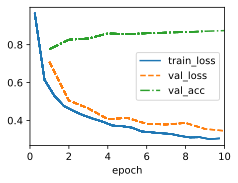

In [26]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

### 8.5.5. Concise Implementation

In [27]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), 
            # pytorch implements: 2d BN
            nn.LazyBatchNorm2d(),
            nn.Sigmoid(), 
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.LazyConv2d(16, kernel_size=5), 
            nn.LazyBatchNorm2d(),
            nn.Sigmoid(), 
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(), 
            
            nn.LazyLinear(120), 
            # pytorch implements: 1d BN
            nn.LazyBatchNorm1d(),
            nn.Sigmoid(),

            nn.LazyLinear(84), 
            nn.LazyBatchNorm1d(),
            nn.Sigmoid(), 
            
            nn.LazyLinear(num_classes))

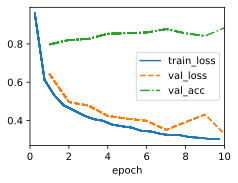

In [28]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)